# I. Introduction




## Libraries

In [ ]:
# Tensorflow Modules
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Scikit-Learn Modules
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Fundamental Modules
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import seaborn as sns

## Helper Functions

In [ ]:
def plot_predictions(train_data, train_labels, test_data, test_labels, val_data, predictions):
    """
    Plot the predicted values along with the actual training, test, and validation data.

    Parameters:
    train_data (numpy.array): Feature values of the training data.
    train_labels (numpy.array): Target values of the training data.
    test_data (numpy.array): Feature values of the test data.
    test_labels (numpy.array): Target values of the test data.
    val_data (numpy.array): Feature values of the validation data.
    predictions (numpy.array): Predicted values for the validation data.

    Returns:
    None
    """

    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", label="Training Data")
    plt.scatter(test_data, test_labels, c="g", label="Test Data")
    plt.scatter(val_data, predictions, c="r", label="Predictions")
    plt.legend()
    plt.xlabel("Input Data")
    plt.ylabel("Output/Predictions")
    plt.title("Actual vs. Predicted Values")
    plt.show()

def divide_to_sets(X: np.array, y: np.array, val_cut: float, test_cut: float):
    """
    Divide the dataset into training, testing, and validation sets.

    Parameters:
    X (numpy.array): Feature values of the dataset.
    y (numpy.array): Target values of the dataset.
    val_cut (float): Proportion of data to be used for validation.
    test_cut (float): Proportion of data to be used for testing.

    Returns:
    tuple: A tuple containing X_train, X_test, y_train, y_test, X_val, y_val.
    """

    validation_size = int(len(X) * val_cut)
    X_val = X[-validation_size:]
    y_val = y[-validation_size:]
    X_train, X_test, y_train, y_test = train_test_split(
        X[:-validation_size],
        y[:-validation_size],
        test_size=test_cut,
        shuffle=True,
        random_state=42
    )

    return X_train, X_test, y_train, y_test, X_val, y_val

def evaluate_regression(y_true, y_pred):
    """
    Evaluate the performance of a regression model using various metrics.

    Parameters:
    y_true (numpy.array): True target values.
    y_pred (numpy.array): Predicted target values.

    Returns:
    pandas.DataFrame: A DataFrame containing metrics such as Mean Absolute Error (MAE),
    Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).
    """

    mae = tf.metrics.mean_absolute_error(y_true, tf.squeeze(y_pred))
    mse = tf.metrics.mean_squared_error(y_true, tf.squeeze(y_pred))
    rmse = np.sqrt(mse)

    metrics_dict = {"mae": mae.numpy(), "mse": mse.numpy(), "rmse": rmse}
    metrics_df = pd.DataFrame(metrics_dict, index=[0])
    return metrics_df


def build_model(loss_metric, optimization_algorithm, eval_metric):

  tf.random.set_seed(42)
  model= tf.keras.Sequential([
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(100, activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(100, activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(100, activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation="linear")
  ])

  model.compile(loss=loss_metric,
                optimizer=optimization_algorithm,
                metrics=eval_metric)

  return model


# II. Data & Methodology

[**Data Source**](https://www.kaggle.com/datasets/mirichoi0218/insurance)

In [ ]:
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
categoric_columns = insurance.select_dtypes(include="object")
for col in categoric_columns.columns:
    unique_values = categoric_columns[col].nunique()
    print(f"Number of Unique values in {col} column: {unique_values}")

Number of Unique values in sex column: 2
Number of Unique values in smoker column: 2
Number of Unique values in region column: 4


In [ ]:
insurance.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


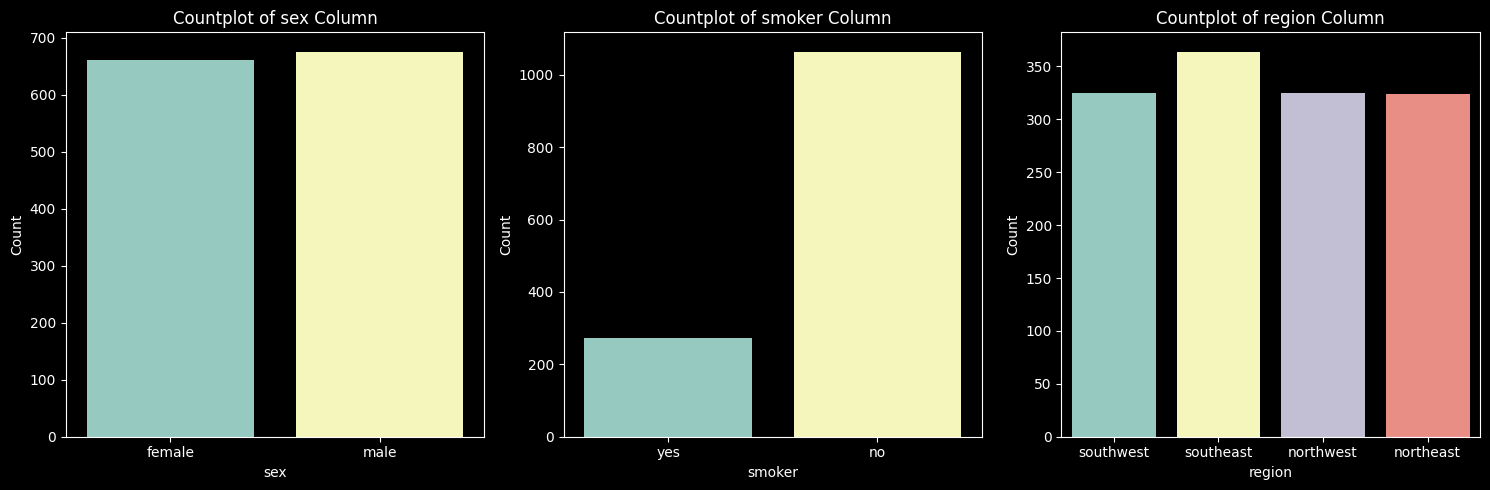

In [ ]:
categoric_columns = insurance.select_dtypes("object").columns

num_plots = len(categoric_columns)
fig, axes = plt.subplots(1, num_plots, figsize=(15, 5))

for i, cat_col in enumerate(categoric_columns):
    sns.countplot(x=cat_col, data=insurance, ax=axes[i])
    axes[i].set_title(f"Countplot of {cat_col} Column")
    axes[i].set_xlabel(cat_col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

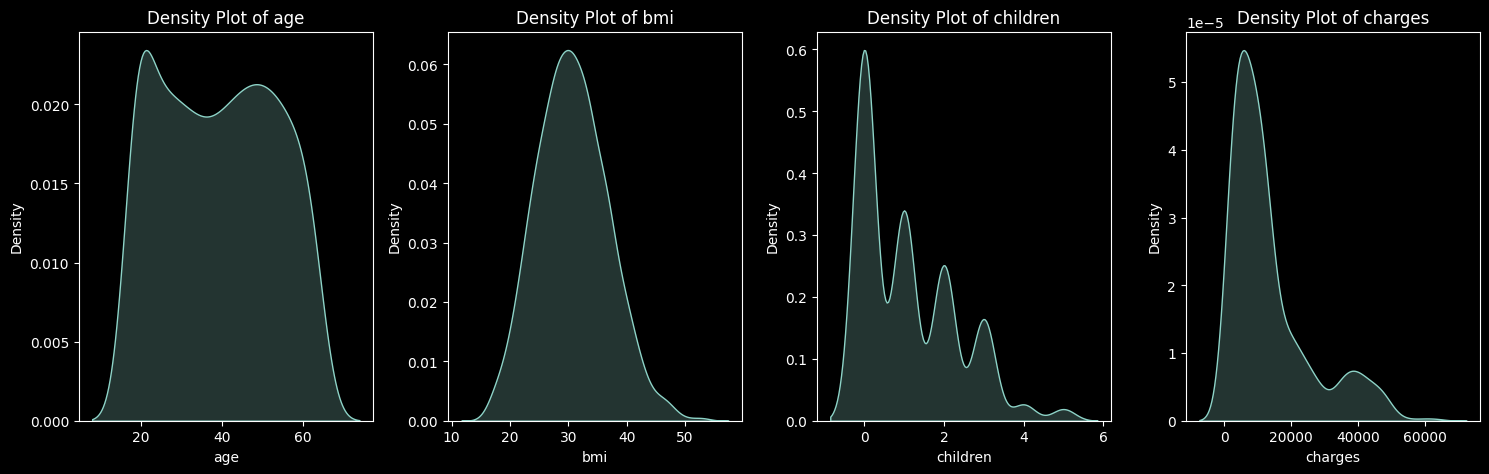

In [ ]:
numeric_columns = insurance.select_dtypes("number").columns

# Create a single figure with subplots
num_plots = len(numeric_columns)
fig, axes = plt.subplots(1, num_plots, figsize=(15, 5))

# Plot density plots for numeric columns in subplots
for i, numeric_col in enumerate(numeric_columns):
    sns.kdeplot(data=insurance, x=numeric_col, fill=True, common_norm=False, ax=axes[i])
    axes[i].set_title(f'Density Plot of {numeric_col}')
    axes[i].set_xlabel(numeric_col)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

## Preprocessing

In [ ]:
# Instantiate the scaler
col_transform = make_column_transformer(
    (MinMaxScaler(), ["age","bmi","children"]),
    (OneHotEncoder(handle_unknown="ignore"), ["sex","smoker","region"])
)

# Separate feature and target
X = insurance.drop(["charges"], axis=1)
y = insurance["charges"]

# Divide data as training, testing and validation sets
X_train, X_test, y_train, y_test, X_val, y_val = divide_to_sets(X, y, val_cut=0.1,test_cut=0.33)

# Fit and Transform training, test, and validation datasets
col_transform.fit(X_train)
X_train_normal = col_transform.transform(X_train) # Transform training set
X_test_normal = col_transform.transform(X_test)   # Transform test set
X_val_normal = col_transform.transform(X_val)     # Transform validation set

In [ ]:
X_train_normal[:5]

array([[0.32608696, 0.53440743, 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.        , 0.73866739, 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        ],
       [0.73913043, 0.430639  , 0.4       , 1.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.54347826, 0.3113053 , 0.6       , 0.        , 1.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.08695652, 1.        , 0.2       , 0.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        ]])

# III. Modelling

## Callbacks

In [ ]:
tf.random.set_seed(42)

# best epoch
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="new_checkpoints/model-{epoch:02d}-{root_mean_squared_error:.3f}.hdf5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# learning rate drop
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_root_mean_squared_error",
    mode="min",
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

# early stopping
cb_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_root_mean_squared_error",
    mode="min",
    min_delta=0.001,
    patience=10,
    verbose=1,
)

# CSV logger
cb_csvlogger = tf.keras.callbacks.CSVLogger(
    filename="training_log.csv",
    separator=",",
    append=False
)

## Building

In [ ]:
epoch = [64,128,256,512]
batch = [8,16,32,64,128,256]
learning_rate = [1e-1, 1e-2, 1e-3, 1e-5]
optimizer_algorithm = [tf.keras.optimizers.SGD, tf.keras.optimizers.Adam]
model_outcomes = []

for optz, epc, btch, lr in product(optimizer_algorithm, epoch, batch, learning_rate):

  dummy_model = build_model(loss_metric=tf.keras.losses.mean_squared_error,
                              optimization_algorithm=optz(lr),
                              eval_metric=tf.metrics.RootMeanSquaredError())

  model_history = dummy_model.fit(X_train_normal, y_train,
                                    validation_data=(X_test_normal, y_test),
                                    epochs=epc,
                                    batch_size=btch,
                                    verbose=1,
                                    callbacks=[cb_checkpoint, cb_reducelr,
                                               cb_earlystop, cb_csvlogger])

  y_preds = dummy_model.predict(X_val_normal)
  model_result = evaluate_regression(y_val, y_preds)

  model_outcome={
      "optimizer":optz,
      "epoch":epc,
      "batch_size":btch,
      "learning_rate":lr,
      "rmse":model_result["rmse"][0]
  }

  model_outcomes.append(model_outcome)

## Evaluation

In [ ]:
model_outcomes_df = pd.DataFrame(model_outcomes)
model_outcomes_df.dropna(inplace=True)
model_outcomes_df.sort_values(by="rmse", ascending=True).head(5)

,optimizer,epoch,batch_size,learning_rate,rmse
73,<class 'keras.optimizers.adam.Adam'>,64,32,0.01000,5204.733887
63,<class 'keras.optimizers.sgd.SGD'>,512,64,0.00001,5243.323730
124,<class 'keras.optimizers.adam.Adam'>,512,64,0.10000,5257.530273
121,<class 'keras.optimizers.adam.Adam'>,512,32,0.01000,5274.824219
76,<class 'keras.optimizers.adam.Adam'>,64,64,0.10000,5285.414062


In [ ]:
try:
    best_regression_model = tf.keras.models.load_model("/content/model-94-4993.673.hdf5")
    if best_regression_model:
      print("Model Loaded Successfuly", "\n")

      best_regression_model.summary()
except FileNotFoundError as e:
    print(f"\nModel Not Found: {e}")

Model Loaded Successfuly 

Model: "sequential_231"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_774 (Ba  (None, 11)               44        
 tchNormalization)                                               
                                                                 
 dense_774 (Dense)           (None, 100)               1200      
                                                                 
 batch_normalization_775 (Ba  (None, 100)              400       
 tchNormalization)                                               
                                                                 
 dropout_312 (Dropout)       (None, 100)               0         
                                                                 
 dense_775 (Dense)           (None, 100)               10100     
                                                                 
 batch_normalization_776 

In [ ]:
best_model_preds = best_regression_model.predict(X_val_normal)
best_model_results = evaluate_regression(y_val, best_model_preds)
best_model_results

5/5 [==============================] - 0s 3ms/step


,mae,mse,rmse
0,2877.739014,27442992.0,5238.605957


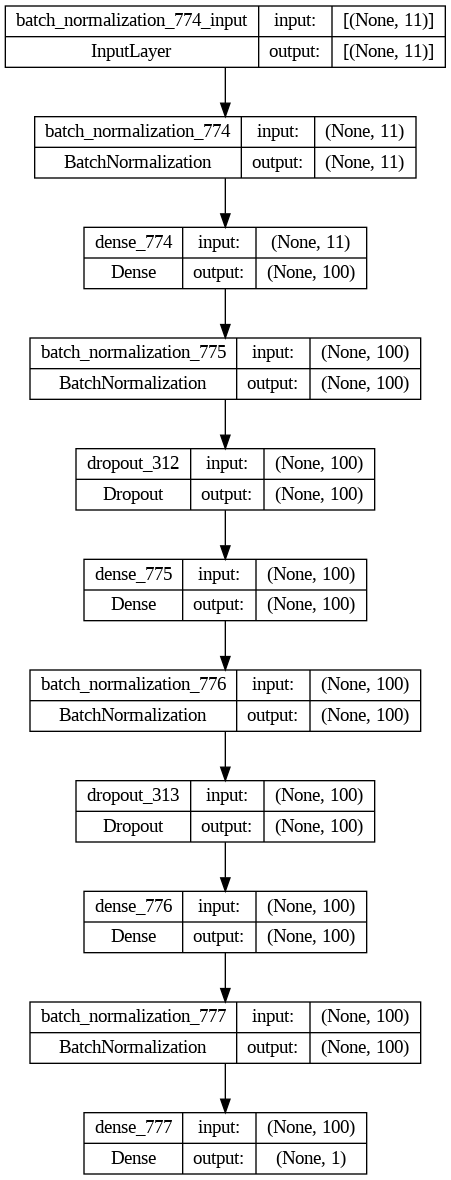

In [ ]:
plot_model(best_regression_model, show_shapes=True)

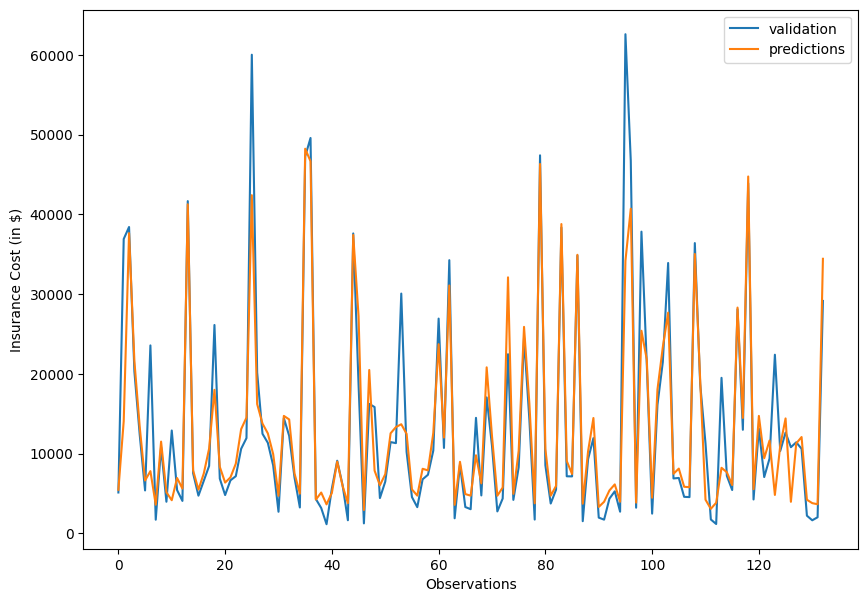

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(y_val.values, label="Actual Values (From Validation Set)")
plt.plot(best_model_preds.flatten(), label="predictions")
plt.legend()
plt.xlabel("Observations")
plt.ylabel("Insurance Cost (in $)");

# IV. Conclusion